## Data

Where does the data come from? -> provide source and background of data

### Data discovery

Before the analysis and preprocessing of the data, the data is $/textit{discovered}$ in order to obtain an overview over what data is available at all.

Integration of necessary libraries and datasets into the notebook.

In [ ]:
!pip3 install pyspark
!pip3 install pandas
!pip3 install matplotlib
!pip3 install -U scikit-learn


In [1]:
!ls /datasets/computational-tools-for-dataanalysis-data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as distance
from scipy import sparse
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.preprocessing import LabelEncoder

Der Befehl "ls" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


#### Review data

The first dataset contains the review data of the books, matching a user with a book and providing a rating that the user gave the book (from 1-5), as well a review description. The dataset contains 3 million book ratings.

In [2]:
#review_data = pd.read_csv("/datasets/computational-tools-for-dataanalysis-data/Books_rating.csv")
review_data = pd.read_csv("C:/Users/paulw/OneDrive - Danmarks Tekniske Universitet/02807 - Computational Tools for Data Science/project/Books_rating.csv")
review_data.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [3]:
#shape of the review dataset
print(review_data.shape)
#columns available in the review dataset
print(review_data.columns)
#remove unnecessary columns from dataset
keep_columns = ['Id', 'Title', 'User_id', 'review/score', 'review/text']
review_data = review_data[keep_columns]

(3000000, 10)
Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')


Number of individual users, 1008972
Maximal number of reviews that a single user submitted, 5795
Number of people that have rated more than 1000 books, 10
Number of people that have rated more than 200 books, 336
Number of people that have rated only one book, 693716
Number of people that have rated more than 5 books, 82795


C:\Users\paulw\AppData\Local\Temp\ipykernel_22944\1150776213.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


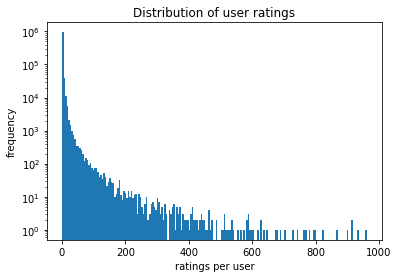

In [4]:
grouped_reviews = review_data.groupby(['User_id']).count()
print(f"Number of individual users, {grouped_reviews.shape[0]}")
#check the maximal number of books a person has rated
print(f"Maximal number of reviews that a single user submitted, {max(grouped_reviews['Id'])}")
#check how many people have rated more than 1000 books
print(f"Number of people that have rated more than 1000 books, {grouped_reviews[grouped_reviews['Id']>=1000].shape[0]}")
#check how many people have rated more than 200 books
print(f"Number of people that have rated more than 200 books, {grouped_reviews[grouped_reviews['Id']>=200].shape[0]}")
#remove people that have judged more than 1000 books 
grouped_reviews = grouped_reviews[grouped_reviews['Id']<=1000]
review_data=review_data[review_data['User_id'].isin(grouped_reviews.index)]
#check number of people that rated only one book
print(f"Number of people that have rated only one book, {grouped_reviews[grouped_reviews['Id']==1].shape[0]}")
#check number of people that rated more than five books
print(f"Number of people that have rated more than 5 books, {grouped_reviews[grouped_reviews['Id']>=5].shape[0]}")
#show the distribution of rated books
fig, ax = plt.subplots()
ax.hist(grouped_reviews['Id'], log=True, bins=200)
ax.set_ylabel('frequency')
ax.set_xlabel('ratings per user')
ax.set_title('Distribution of user ratings')
fig.show()

The dataset contains 1008972 unique users of which every user has rated 2.97 books in average. However, the majority of the users has only rated one book (68.75%), and only few users (8.21%) have rated more than 5 books. 10 users have rated more than 1000 books. These users were removed from the dataset as outliers, because it is assumed that their rating behaviour will not be valuable to make predictions to for other users.

Number of rated books, 205047
Number of books that have been rated once, 69558
Book with most ratings is 'The Hobbit' with 18059 ratings.


C:\Users\paulw\AppData\Local\Temp\ipykernel_22944\4094988773.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


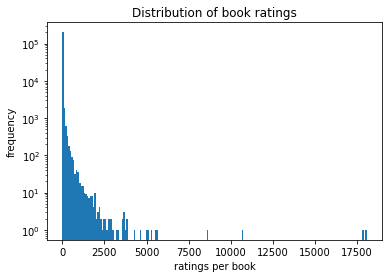

In [5]:
grouped_books = review_data.groupby(['Title']).count()
print(f"Number of rated books, {grouped_books.shape[0]}")
print(f"Number of books that have been rated once, {grouped_books[grouped_books['Id']==1].shape[0]}")
print(f"Book with most ratings is '{review_data[review_data['Title']==grouped_books[grouped_books['Id']==max(grouped_books['Id'])].index[0]]['Title'].reset_index(drop=True)[0]}' with {max(grouped_books['Id'])} ratings.")
fig, ax = plt.subplots()
ax.hist(grouped_books['Id'], log=True, bins=200)
ax.set_ylabel('frequency')
ax.set_xlabel('ratings per book')
ax.set_title('Distribution of book ratings')
fig.show()

In total 205047 books have been rated, of which 33.92% have been rated once. The book with the most ratings is 'The Hobbit' with 18059 ratings.

In [6]:
print(review_data[review_data['Title'].str.contains('Hobbit',na=False)])

                 Id                                              Title  \
86547    B000NWU3I4  The Hobbitt, or there and back again; illustra...   
86548    B000NWU3I4  The Hobbitt, or there and back again; illustra...   
86549    B000NWU3I4  The Hobbitt, or there and back again; illustra...   
86550    B000NWU3I4  The Hobbitt, or there and back again; illustra...   
86551    B000NWU3I4  The Hobbitt, or there and back again; illustra...   
...             ...                                                ...   
2978151  B000Q032UY                 The Hobbit or There and Back Again   
2978152  B000Q032UY                 The Hobbit or There and Back Again   
2978153  B000Q032UY                 The Hobbit or There and Back Again   
2978154  B000Q032UY                 The Hobbit or There and Back Again   
2978155  B000Q032UY                 The Hobbit or There and Back Again   

                User_id  review/score  \
86547     AXX9R9P27CFFS           5.0   
86548    A3VKLBHDXSJADC      

#### Book data

The second dataset contains information about the books themselves. Including the book title and Id, the author a description of the book and a book category. Furthermore, the book dataset contains a column with the average user rating.

In [7]:
#books_data = pd.read_csv("/datasets/computational-tools-for-dataanalysis-data/books_data.csv")
books_data = pd.read_csv("C:/Users/paulw/OneDrive - Danmarks Tekniske Universitet/02807 - Computational Tools for Data Science/project/books_data.csv")
books_data.head

<bound method NDFrame.head of                                                     Title  \
0                          Its Only Art If Its Well Hung!   
1                                Dr. Seuss: American Icon   
2                   Wonderful Worship in Smaller Churches   
3                           Whispers of the Wicked Saints   
4       Nation Dance: Religion, Identity and Cultural ...   
...                                                   ...   
212399  The Orphan Of Ellis Island (Time Travel Advent...   
212400                            Red Boots for Christmas   
212401                                              Mamaw   
212402                                  The Autograph Man   
212403  Student's Solutions Manual for Johnson/Mowry's...   

                                              description  \
0                                                     NaN   
1       Philip Nel takes a fascinating look into the k...   
2       This resource includes twelve principles in un

In [8]:
#shape of the book dataset
print(books_data.shape)
#columns available in the review dataset
print(books_data.columns)
#remove unnecessary columns from dataset
keep_columns = ['Title', 'description', 'authors', 'categories', 'ratingsCount']
books_data = books_data[keep_columns]

(212404, 10)
Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'publishedDate', 'infoLink', 'categories', 'ratingsCount'],
      dtype='object')


In [9]:
print(f"Number of books that have a ratings count in this dataset, {books_data[books_data['ratingsCount']>0].shape[0]}")
print(books_data[books_data['Title'].str.contains('Hobbit',na=False)])

grouped_books = books_data.groupby(['authors']).count()
grouped_books[grouped_books['Title']>=5]

Number of books that have a ratings count in this dataset, 49752
                                                    Title  \
5970    The Hobbitt, or there and back again; illustra...   
29057                                          The Hobbit   
64705   The Lord of the Rings and The Hobbit (Cliffs N...   
86754   Hobbits, Elves and Wizards: The Wonders and Wo...   
89208   Hobbit and The Lord of the Rings, The (Barron'...   
89771                The Hobbit; Or, There and Back Again   
130707                 The Hobbit or There and Back Again   
159000                    The Hobbit There and Back Again   
176456                              Poems from The Hobbit   
188737                              Poems from the Hobbit   
189955  The Individuated Hobbit: Jung, Tolkien and the...   

                                              description  \
5970    Bilbo Baggins, a respectable, well-to-do hobbi...   
29057   Celebrating 75 years of one of the world's mos...   
64705   Join the jo

,Title,description,categories,ratingsCount
authors,,,,
"[""America's Test Kitchen""]",7,7,7,3
"[""Bathroom Readers' Institute""]",5,5,5,5
"[""Eugene O'Neill""]",12,8,11,4
"[""Fodor's Travel Guides""]",5,5,5,0
"[""Fodor's Travel Publications, Inc. Staff""]",5,5,5,0
...,...,...,...,...
"['Zondervan,']",20,20,20,15
['Zora Neale Hurston'],10,10,10,5
['bell hooks'],16,16,16,10


In [10]:
#check how many of the reviewed books are available in the book dataset by Title
merged_df = pd.merge(review_data, books_data, how='inner', on=['Title'])
print(merged_df.shape)
merged_df.head()

(2415682, 9)


,Id,Title,User_id,review/score,review/text,description,authors,categories,ratingsCount
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,4.0,This is only for Julie Strain fans. It's a col...,NaN,['Julie Strain'],['Comics & Graphic Novels'],NaN
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,5.0,I don't care much for Dr. Seuss but after read...,Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography'],NaN
2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,5.0,"If people become the books they read and if ""t...",Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography'],NaN
3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography'],NaN
4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,4.0,Philip Nel - Dr. Seuss: American IconThis is b...,Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography'],NaN


### Creating an item profile 
In order to create an item profile, the authors and category are put into a 

Calculate the cosine distance between two matrices

In [11]:
import numpy as np
import scipy.spatial.distance as distance
from scipy import sparse

### Creating the normalized utility matrix
If we had more than our local machines available, it would make sense to use distributed machines with map-reduce in order to handle this problem.
The utility matrix already gets fairly big if we want to process it in a dense format.

In [12]:
# Calculating the average rating of each user
avg_rating = (merged_df[["User_id", "review/score"]].
groupby("User_id").mean())

In [13]:
print(f"Number of books in the merged dataset {len(merged_df['Title'].drop_duplicates())}")
print(f"Number of users in the merged dataset {len(merged_df['User_id'].drop_duplicates())}")

Number of books in the merged dataset 205048
Number of users in the merged dataset 1008962


This means our utility matrix will end up being 1008962x205048 - a very large matrix.
In order to handle a matrix of this size, we need to look at sparse matrices (most entries will be empty anyways)

In [14]:
merged_df[["Title", "User_id", "review/score"]].sort_values(["User_id", "Title"])
# looking at this it looks as if some users rated the same book twice (the title only varies slightly)
# look at id 750686 & 1357681]

,Title,User_id,review/score
1530761,This Calder Range (Calder Saga's),A00109803PZJ91RLT7DPN,5.0
1125585,The Queen of Harlem: A Novel,A00117421L76WVWG4UX95,5.0
1510574,ATTITUDE 101,A0015610VMNR0JC9XVL1,3.0
750686,The Richest Man in Babylon,A0015610VMNR0JC9XVL1,5.0
1357681,The richest man in Babylon,A0015610VMNR0JC9XVL1,5.0
...,...,...,...
1281294,Tactics of the Crescent Moon: Militant Muslim ...,AZZZT14MS21I6,5.0
1279708,The Tiger's Way: A U.S. Private's Best Chance ...,AZZZT14MS21I6,5.0
1895267,Out,AZZZYCR4NZADZ,5.0
1895413,Out,AZZZYCR4NZADZ,5.0


In [15]:
(merged_df[~merged_df["Title"]
    .apply(lambda x:isinstance(x, str))])

,Id,Title,User_id,review/score,review/text,description,authors,categories,ratingsCount
17063,B00005XZDV,NaN,AY44TQ8XGQ7RR,5.0,In an era of other prolific writers such as Ja...,NaN,['Maharshi Ramana'],NaN,1.0
17064,0801841119,NaN,A3F19JZZ07PDX0,1.0,You can't even really call this a translation;...,NaN,['Maharshi Ramana'],NaN,1.0
17065,0801841119,NaN,A1JO4MQFLXGYVS,5.0,Slavitt's translation of Virgil's Eclogues and...,NaN,['Maharshi Ramana'],NaN,1.0
17066,0595241034,NaN,A1ASFZRH6ZLCOE,4.0,I can definitely relate to the story line in D...,NaN,['Maharshi Ramana'],NaN,1.0
17067,0595241034,NaN,AIY736C2LYMMB,3.0,This new author has taken on a very sensitive ...,NaN,['Maharshi Ramana'],NaN,1.0
...,...,...,...,...,...,...,...,...,...
17253,059528812X,NaN,A6SZZSMX7DQG1,5.0,"This is a great book about friendship, loyalty...",NaN,['Maharshi Ramana'],NaN,1.0
17254,059528812X,NaN,A352HZ1YURWGVL,1.0,I saw this title in my local library on the do...,NaN,['Maharshi Ramana'],NaN,1.0
17255,059528812X,NaN,A2VPLBU4M5NUXV,5.0,Justify The Means offers bone-deep emotional t...,NaN,['Maharshi Ramana'],NaN,1.0
17256,059528812X,NaN,AVDFWLRZRBTMI,5.0,"With keen prose and an extraordinary eye, Madi...",NaN,['Maharshi Ramana'],NaN,1.0


In [16]:
# Drop NaN values and cast the title to lower case
merged_df = merged_df.drop(merged_df[~merged_df["Title"].apply(lambda x:isinstance(x, str))].index)
merged_df["Title"] = merged_df["Title"].apply(lambda x:x.lower())

In [17]:
print(f"Unique reviews in the dataset considering Title and score per user: {merged_df[['Title', 'User_id', 'review/score']].drop_duplicates().shape[0]}")
print(f"Unique reviews in the dataset considering only Title: {merged_df[['Title', 'User_id']].drop_duplicates().shape[0]}")

# We can see that approx. 2000 people have rated a book twice and given it a different rating

Unique reviews in the dataset considering Title and score per user: 2032945
Unique reviews in the dataset considering only Title: 2030641


If we normalize the ratings by the average rating given from a user, we will essentially get rid of all the people that have only voted once, and people that have only given the same rating across multiple books. This is an assumption we work with for now.

In [18]:
#ratings_ = pd.merge(merged_df["review/score"], avg_rating, how="outer", left_index=True, right_index=True)
#ratings_ = pd.merge(merged_df["review/score"], avg_rating, how="inner", left_index=True, right_index=True)

In [19]:
# calculate normalized ratings (rating - mean rating)
#avg_rtng = (ratings_.iloc[:,0]-ratings_.iloc[:,1]).values

NameError: name 'ratings_' is not defined

In [20]:
from sklearn.datasets import make_sparse_spd_matrix

In [21]:
#https://towardsdatascience.com/working-with-sparse-data-sets-in-pandas-and-sklearn-d26c1cfbe067
#ut_mat = pd.get_dummies(merged_df[['Title', 'User_id', 'review/score']], columns=["Title", "User_id"], sparse=True)

Using an Encoder for the string variables saves a lot of memory for computations. We can always go invert the mapping to get to the original values.

In [22]:
from sklearn.preprocessing import LabelEncoder
# Encode the User_id and Title
le = LabelEncoder()
merged_df["User_id"] = le.fit_transform(merged_df["User_id"])
#merged_df["User_id"] = merged_df["User_id"].astype("category")

In [23]:
le2 = LabelEncoder()
merged_df["Title"] = le2.fit_transform(merged_df["Title"])
#merged_df["Title"] = merged_df["Title"].astype("category")

In [24]:
merged_df.head()

,Id,Title,User_id,review/score,review/text,description,authors,categories,ratingsCount
0,1882931173,79922,974347,4.0,This is only for Julie Strain fans. It's a col...,NaN,['Julie Strain'],['Comics & Graphic Novels'],NaN
1,0826414346,45723,538921,5.0,I don't care much for Dr. Seuss but after read...,Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography'],NaN
2,0826414346,45723,758556,5.0,"If people become the books they read and if ""t...",Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography'],NaN
3,0826414346,45723,436234,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography'],NaN
4,0826414346,45723,288496,4.0,Philip Nel - Dr. Seuss: American IconThis is b...,Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography'],NaN


In [29]:
ratings_unique = merged_df[["Title", "User_id", "review/score"]].groupby(["Title", "User_id"]).mean().reset_index()

In [30]:
# Calculating the average rating of each user
avg_rating = (ratings_unique[["User_id", "review/score"]].
groupby("User_id").mean())

In [262]:
ratings_ = pd.merge(ratings_unique[["review/score", "User_id", "Title"]], avg_rating, how="outer", left_on="User_id", right_index=True)

In [32]:
avg_rtng = (ratings_.iloc[:,0]-ratings_.iloc[:,2]).values

In [266]:
ratings_unique

,Title,User_id,review/score
0,0,49368,5.0
1,0,723042,4.0
2,1,514029,5.0
3,1,777643,5.0
4,2,190516,4.0
...,...,...,...
2030636,202225,375630,4.0
2030637,202225,683783,4.0
2030638,202225,850622,5.0
2030639,202225,937049,5.0


In [34]:
ratings_["avg"] = ratings_.iloc[:,0]-ratings_.iloc[:,2]

In [35]:
ratings_[ratings_["avg"]>0]["User_id"].drop_duplicates()

1          723042
3          777643
5530       809105
208308       9833
19          12345
            ...  
2025946     52719
2029713    911886
2026137    153172
2026179    318173
2028595    677411
Name: User_id, Length: 115157, dtype: int64

In [36]:
sparse_matrix = sparse.csc_matrix((avg_rtng, (ratings_unique["User_id"].values, ratings_unique["Title"].values)), shape=(ratings_unique["User_id"].nunique(), ratings_unique["Title"].nunique()))

In [37]:
print(sparse_matrix[2])

  (0, 16913)	1.2857142857142856
  (0, 174257)	0.0
  (0, 174258)	0.0


In [38]:
sparse_matrix

<1008951x202226 sparse matrix of type '<class 'numpy.float64'>'
	with 2030641 stored elements in Compressed Sparse Column format>

In [39]:
print(sparse_matrix[:,0])

  (49368, 0)	0.0
  (723042, 0)	0.0


In [40]:
sparse_matrix[0]

<1x202226 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Column format>

In [41]:
import copy

In [42]:
sm_c = copy.deepcopy(sparse_matrix)

In [43]:
sm_c.eliminate_zeros()

In [44]:
sm_c

<1008951x202226 sparse matrix of type '<class 'numpy.float64'>'
	with 818395 stored elements in Compressed Sparse Column format>

Unfortunately the distance metrics in scipy can't work with sparse matrices, so we need to find an alternative
https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy

In [49]:
from sklearn.cluster import KMeans

In [119]:
#num_clust =[int(np.floor(115000/j)) for j in reversed(range(2,10))]
#num_clust = num_clust[0:1]
#num_clust = range(1,11)

range(1, 11)


If we try to cluster our utility matrix, we run into an impass. The runtime will be way to long on any of our machines to get meaningful results.
Thus, we need to try another approach.

In [54]:
#distortions = []
#for i in [2]:
#    km = KMeans(n_clusters=i,
#                init='k-means++', # this can be left out, as it is the default
#                n_init=10,
#                max_iter=300,
#                random_state=0)
#    km.fit(sm_c)
#    distortions.append(km.inertia_)

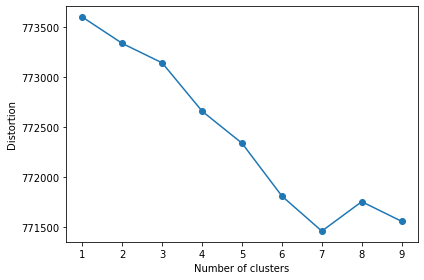

In [73]:
#plt.plot(range(1,10), distortions , marker='o')
#plt.xlabel('Number of clusters')
#plt.ylabel('Distortion')
#plt.tight_layout()
##plt.savefig('./figures/elbow.png', dpi=300)
#plt.show()

I get rid of all entries which have a rating of 0 after normalizing, since we will not be able to infer anything for them and they are stored explicitly, thus creating a lot of additional entries
In order to create a sparse matrix the ids need to be in consecutive order

In [272]:
ruc = copy.deepcopy(ratings_unique)

In [279]:
ruc = ruc.reindex(index=ratings_.reset_index()["index"])
ruc["avg"] = avg_rtng

In [ ]:
#ratings_unique_small = ratings_unique[avg_rtng!=0]
ratings_unique_small = ruc[avg_rtng!=0]

In [56]:
#https://datagy.io/python-create-dictionary-from-two-lists/
# In order to use the csc_sparse_matrix the values need to be continuous, thus I need to remap all the values _again_
dict_users = dict(zip(ratings_unique_small["User_id"].unique(),range(ratings_unique_small["User_id"].nunique())))

In [57]:
ratings_unique_small["User_map"] = ratings_unique_small["User_id"].map(dict_users)

C:\Users\paulw\AppData\Local\Temp\ipykernel_22944\1097239505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_unique_small["User_map"] = ratings_unique_small["User_id"].map(dict_users)


In [58]:
dict_titles = dict(zip(ratings_unique_small["Title"].unique(),range(ratings_unique_small["Title"].nunique())))
ratings_unique_small["Title_map"] = ratings_unique_small["Title"].map(dict_titles)

C:\Users\paulw\AppData\Local\Temp\ipykernel_22944\1534806831.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_unique_small["Title_map"] = ratings_unique_small["Title"].map(dict_titles)


In [59]:
reduced_sparse = sparse.csc_matrix((avg_rtng[avg_rtng!=0], (ratings_unique_small["User_map"].values, ratings_unique_small["Title_map"].values)), shape=(ratings_unique_small["User_map"].nunique(), ratings_unique_small["Title_map"].nunique()))

In [60]:
reduced_sparse

<500043x109360 sparse matrix of type '<class 'numpy.float64'>'
	with 818395 stored elements in Compressed Sparse Column format>

After getting rid of all the 0 values in our sparse matrix, we reduced the number of entries to 1/4 of the original sparse matrix

In [122]:
num_clust =[int(np.floor(100000/j)) for j in reversed(range(2,10))]

In [123]:
num_clust

[11111, 12500, 14285, 16666, 20000, 25000, 33333, 50000]

FileNotFoundError: [Errno 2] No such file or directory: './figures/elbow.png'

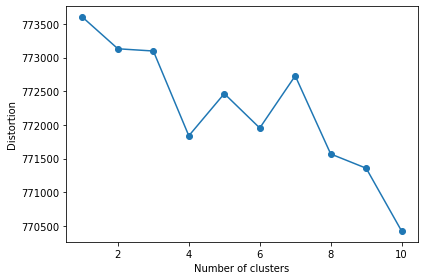

In [125]:
distortions = []
for i in range(1,11):
    km = KMeans(n_clusters=i,
                init='k-means++', # this can be left out, as it is the default
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(reduced_sparse)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions , marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('28156/elbow.png', dpi=300)
plt.show()

### Looking at matrix factorization or UV-Decomposition
I couldn't find any direct suggested value for choosing d, so I will just run with one and then see how it goes

the standard deviation of our ratings is approx. 1, so I just randomly initialize u and v with normally distributed random variables

In [78]:

u = np.random.default_rng().normal(0,1,(reduced_sparse.shape[0],100))
v = np.random.default_rng().normal(0,1,(100, reduced_sparse.shape[1]))

In [142]:
tup = ratings_unique_small[["User_map", "Title_map"]].to_records().tolist()

In [166]:
ratings_unqi = ratings_unique_small[["User_map", "Title_map"]].set_index("User_map")

In [191]:
preds = []
for p in range(ratings_unique_small.shape[0]):
    #ratings_unqi.loc[p].T.to_numpy()[0])
    preds.append(np.dot(u[p,:],v[:,ratings_unqi.loc[p].T.to_numpy()[0]]))

KeyboardInterrupt: 

In [291]:
np.dot(u[0,:],v[:,ratings_unqi.loc[0].T.to_numpy()[0]])

array([ -3.1240564 ,  -5.28145968,  -7.91701832,  -6.99759407,
         0.35972836,  -6.14654056,   8.58066956,  -0.30531048,
        -2.18120336, -20.15577403,  -3.46829156, -21.00361329,
         0.94442102,   6.38796669,   6.9286729 ,  14.55232907,
         0.80970023,  -4.08067676,  -3.40437639, -10.27985628,
         2.08682006,   8.00048855,  -7.5307294 , -12.23636207,
         5.35375207])

In [306]:
print(((reduced_sparse[1]-pred_0).power(2)).sum())

1575.2513032357006


In [217]:
#ratings_unique_small["avg"] = avg_rtng[avg_rtng!=0]

C:\Users\paulw\AppData\Local\Temp\ipykernel_22944\4074258280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_unique_small["avg"] = avg_rtng[avg_rtng!=0]


In [218]:
ratings_unique_small

,Title,User_id,review/score,User_map,Title_map,avg
2,1,514029,5.0,0,0,0.133333
3,1,777643,5.0,1,0,-0.866667
4,2,190516,4.0,2,1,0.133333
5,3,399735,5.0,3,2,0.133333
6,3,643514,5.0,4,2,0.133333
...,...,...,...,...,...,...
2028446,202007,953713,4.0,500039,109358,-0.500000
2029336,202092,861018,5.0,500040,109359,-0.750000
2029337,202092,861793,3.0,500041,109359,-0.750000
2029338,202092,878458,5.0,500042,109359,-0.750000


In [313]:
def predict(df, user_index, u, v):
    y_hat = np.dot(u[user_index,:],v[:,ratings_unqi.loc[user_index].T.to_numpy()[0]])
    return y_hat

In [424]:
def cost(df, index, u, v):
    ### Get the number of entries for this specific user index
    ### and calculate dot-product of the two embedding vectors
    ### transform result into a sparse matrix to calculate sum of squares
    num_ratings_user = len(ratings_unqi.loc[index].reset_index()["User_map"].values)
    #print(num_ratings_user)
    y_hat_sparse = sparse.csc_matrix((predict(0,index,u,v),
                    (np.zeros(num_ratings_user), ratings_unqi.loc[index].reset_index()["Title_map"].values)),
                    shape=(1, ratings_unique_small["Title_map"].nunique()))
    # calculate MSE for embeddings
    return np.sqrt(((reduced_sparse[index]-y_hat_sparse).power(2)).sum()/num_ratings_user)

In [ ]:
def cost(df, index, u, v):
    ### Get the number of entries for this specific user index
    ### and calculate dot-product of the two embedding vectors
    ### transform result into a sparse matrix to calculate sum of squares
    num_ratings_user = len(ratings_unqi.loc[index].reset_index()["User_map"].values)
    #print(num_ratings_user)
    y_hat_sparse = sparse.csc_matrix((predict(0,index,u,v),
                    (np.zeros(num_ratings_user), reduced_sparse.getrow(index).indices)),
                    shape=(1, ratings_unique_small["Title_map"].nunique()))
    # calculate MSE for embeddings
    return np.sqrt(((reduced_sparse[index]-y_hat_sparse).power(2)).sum()/num_ratings_user)

In [241]:
pred_0 = sparse.csc_matrix((np.dot(u[1,:],v[:,ratings_unqi.loc[1].T.to_numpy()[0]]),
 (np.zeros(len(ratings_unqi.loc[1].reset_index()["User_map"].values)), ratings_unqi.loc[1].reset_index()["Title_map"].values)),
 shape=(1, ratings_unique_small["Title_map"].nunique()))

In [429]:
reduced_sparse.getrow(0).indices

array([     0,    520,    554,   2934,  17562,  20725,  27232,  34606,
        38685,  39149,  41034,  49380,  53152,  55284,  55574,  59679,
        61303,  61809,  73202,  82281,  82482,  84324,  87576,  88525,
       106710], dtype=int32)

In [431]:
ratings_unqi.loc[0].reset_index()["Title_map"].values

array([     0,    520,    554,   2934,  17562,  20725,  27232,  34606,
        38685,  39149,  41034,  49380,  53152,  55284,  55574,  59679,
        61303,  61809,  73202,  82281,  82482,  84324,  87576,  88525,
       106710], dtype=int64)

In [ ]:
def gradient():
    residuals = cost(df, index, u, v)
    return True

In [425]:
p_1 = cost(0,1, u,v)

In [426]:
print(p_1)

17.749655226148484


In [336]:
np.dot(p_1.data,v[:,ratings_unqi.loc[1].T.to_numpy()[0]])

ValueError: shapes (5,) and (100,5) not aligned: 5 (dim 0) != 100 (dim 0)

In [337]:
p_1.data

array([245.28430341, 949.15820687, 368.49450506,   1.68547027,
        10.62881762])

In [413]:
np.multiply(v[:,ratings_unqi.loc[1].to_numpy()[0]], v[:,ratings_unqi.loc[1].to_numpy()[0]].T)

array([[ 0.11108952,  0.09753312,  0.45723812, ..., -0.10091931,
        -0.17960401,  0.05464881],
       [ 0.09753312,  0.08563103,  0.40144077, ..., -0.088604  ,
        -0.1576867 ,  0.04797995],
       [ 0.45723812,  0.40144077,  1.88196605, ..., -0.41537814,
        -0.73923985,  0.22493139],
       ...,
       [-0.10091931, -0.088604  , -0.41537814, ...,  0.09168019,
         0.16316133, -0.04964573],
       [-0.17960401, -0.1576867 , -0.73923985, ...,  0.16316133,
         0.29037482, -0.08835348],
       [ 0.05464881,  0.04797995,  0.22493139, ..., -0.04964573,
        -0.08835348,  0.02688366]])

In [385]:
np.multiply(p_1.data,v[:,ratings_unqi.loc[1].T.to_numpy()[0]])

array([[ 8.17534896e+01, -2.28328843e+02, -2.73579748e+02,
        -9.68221562e-01,  1.10891505e+01],
       [ 7.17770067e+01, -1.46684626e+03, -7.20158607e+01,
         1.41791190e+00,  5.70742680e+00],
       [ 3.36492702e+02, -4.80383799e+02,  4.89465635e+02,
        -2.03428049e+00, -1.97273281e+01],
       [ 2.13146162e+02, -7.07699690e+02, -3.43754279e+02,
         1.24909487e+00, -1.26219474e+01],
       [-1.67910185e+02, -1.27395828e+03, -5.86902335e+02,
        -2.73976860e+00, -8.69979920e+00],
       [ 1.75740717e+02, -1.46641027e+02,  3.00108012e+02,
        -5.87230109e+00,  1.20601405e+01],
       [-6.05615775e+01, -5.38145112e+02, -1.00198256e+02,
        -3.92646441e+00, -1.64396417e+00],
       [ 4.32404406e+02,  8.98544323e+02, -4.84103098e+02,
        -7.53842282e-01, -5.73234564e+00],
       [ 4.17443738e+02,  9.19008519e+02,  1.93563358e+02,
         2.12874104e+00, -8.07370118e+00],
       [ 2.53475124e+02,  2.26202204e+03,  9.30149135e+01,
        -5.41816122e+00

In [381]:
np.linalg.inv(np.dot(v[:,ratings_unqi.loc[1].T.to_numpy()[0]], v[:,ratings_unqi.loc[1].T.to_numpy()[0]].T))

(100, 100)

In [364]:
np.multiply(np.linalg.inv(np.dot(v[:,ratings_unqi.loc[1].T.to_numpy()[0]], v[:,ratings_unqi.loc[1].T.to_numpy()[0]].T)).sum(axis=1), np.multiply(p_1.data,v[:,ratings_unqi.loc[1].T.to_numpy()[0]]))

ValueError: operands could not be broadcast together with shapes (100,) (100,5) 

In [367]:
np.linalg.inv(np.dot(v[:,ratings_unqi.loc[1].T.to_numpy()[0]], v[:,ratings_unqi.loc[1].T.to_numpy()[0]].T)).shape

(100, 100)

In [369]:
v[:,ratings_unqi.loc[1].T.to_numpy()[0]].shape

(100, 5)

In [370]:
v[:,ratings_unqi.loc[1].T.to_numpy()[0]]

(100, 109360)

In [371]:
ratings_unqi.loc[1].T.to_numpy()[0]

array([    0,  1206,  9901, 34598, 34599], dtype=int64)

In [376]:
np.linalg.inv(np.multiply(v[:,1206],v[:,1206].T))

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

In [380]:
np.dot(v[:,1206],v[:,1206].T)

140.13800920996468

In [433]:
!pip3 install implicit

     -------------------------------------- 646.1/646.1 kB 8.2 MB/s eta 0:00:00


In [434]:
import implicit

In [499]:
model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.05, iterations=20, alpha=40.0)
alpha_val = 40
data_conf = (reduced_sparse_T).astype('double')
model.fit(data_conf)

C:\Users\paulw\anaconda3\lib\site-packages\implicit\utils.py:138: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.01700592041015625 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [474]:
reduced_sparse_T = sparse.csc_matrix((avg_rtng[avg_rtng!=0], (ratings_unique_small["Title_map"].values, ratings_unique_small["User_map"].values)), shape=(ratings_unique_small["Title_map"].nunique(), ratings_unique_small["User_map"].nunique()))

In [475]:
reduced_sparse_T

<109360x500043 sparse matrix of type '<class 'numpy.float64'>'
	with 818395 stored elements in Compressed Sparse Column format>

In [501]:
model.recommend(0, reduced_sparse.tocsr().getrow(0))

(array([33348, 18402, 17065,  7591,  1282, 20345,  2648,  2794, 10713,
         9026]),
 array([0.00199514, 0.00164966, 0.00130989, 0.00122594, 0.00114854,
        0.0011355 , 0.00112968, 0.00112269, 0.0010939 , 0.00108983],
       dtype=float32))

In [491]:
model.recommend(0, reduced_sparse_T.tocsr().getrow(0))

(array([54082, 78788, 78787, 14755, 79931, 96941,  2420, 83656,   378,
        21774]),
 array([0.09981678, 0.07847066, 0.07719742, 0.06670599, 0.06091911,
        0.05958593, 0.05874689, 0.05769978, 0.0511895 , 0.05087493],
       dtype=float32))

In [446]:
reduced_sparse.T.tocsr()

<109360x500043 sparse matrix of type '<class 'numpy.float64'>'
	with 818395 stored elements in Compressed Sparse Row format>

     -------------------------------------- 281.4/281.4 MB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 199.7/199.7 kB 11.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=d89b1465f5a890974a6f509242e90783d35d847b5075a1594af9b9aa18903ed1
  Stored in directory: c:\users\paulw\appdata\local\pip\cache\wheels\43\dc\11\ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [493]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [507]:
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(reduced_sparse)

AssertionError: 

In [508]:
spark_df = spark.createDataFrame(
    [(0, 0, 4.0), (0, 1, 2.0), (1, 1, 3.0), (1, 2, 4.0), (2, 1, 1.0), (2, 2, 5.0)],
    ["user", "item", "rating"])

AttributeError: module 'pyspark' has no attribute 'createDataFrame'